In [1]:
# import libaries
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
from time import time
from time import perf_counter

#import costum modules
import simulation.initialization as init
import simulation.geometry as geom
import simulation.dynamics as dyn
import simulation.analysis as ana
import simulation.visualization as vis
import simulation.utils as utils

from simulation.geometry import voronoi_tessellation, properties_of_voronoi_tessellation, apply_mic, polygon_perimeter, polygon_area, find_shared_vertices, reorder_two_by_distance
# import functions
from simulation import (
    initialize_box,
    load_configuration,
    update_positions_and_polarizations,
    voronoi_tessellation,
    rdf_pol_alignment_avg,
    compute_msd_cm,
    plot_voronoi,
    make_video_from_images,
    
)

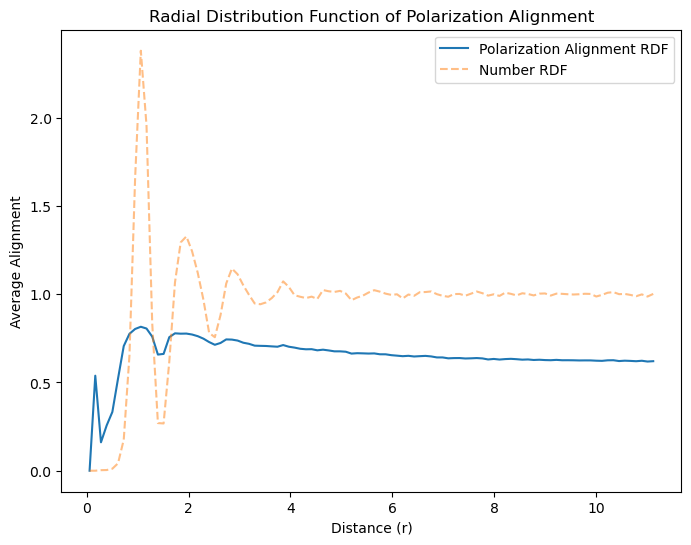

In [2]:
run = 'solid_flocking'
vis.rdf_pol_alignment_plot(run)

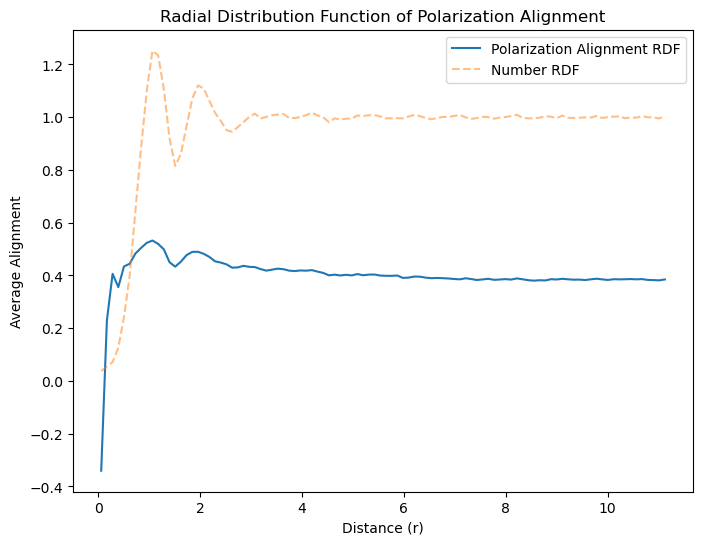

In [3]:
run = 'liquid_flocking'
vis.rdf_pol_alignment_plot(run)

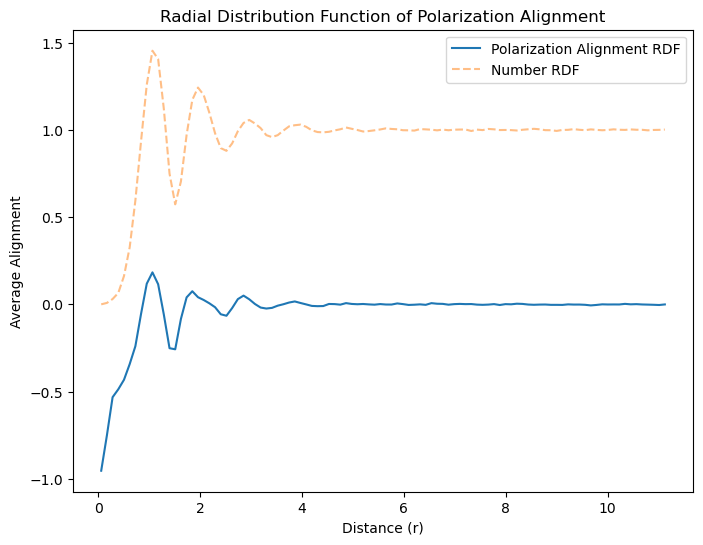

In [4]:
run = 'solid_phi_1.0'
vis.rdf_pol_alignment_plot(run)

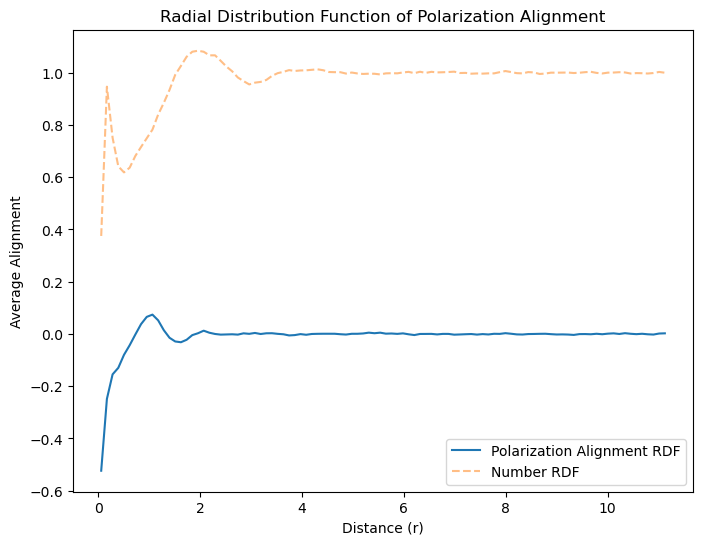

In [5]:
run = 'liquid_phi_1.0'
vis.rdf_pol_alignment_plot(run)

In [2]:
pos, pol = init.load_configuration("test3")

In [8]:
params = init.load_params("test3")
print(params)
K_A = params["K_A"]
K_P = params["K_P"]
A_0 = params["A_0"]
P_0 = params["P_0"]
N = params["N"]
L = params["L"]

{'N': 100.0, 'phi': 1.0, 'L': 10.0, 'dt': 0.01, 'T': 1.0, 'steps': 100.0, 'mu': 1.0, 'J': 8.0, 'D_r': 0.5, 'K_A': 1.0, 'A_0': 1.0, 'K_P': 1.0, 'P_0': 3.0, 'f_0': 1.0}


In [19]:
forces_fast = dyn.compute_tissue_force(pos, K_A, K_P, A_0, P_0, L, N)
forces_slow = dyn.compute_tissue_force_slow(pos, K_A, K_P, A_0, P_0, L, N)
forces_fast_slow_diff = np.linalg.norm(forces_fast - forces_slow, axis=1)
print("Difference between fast and slow force computation:", forces_fast_slow_diff)

Difference between fast and slow force computation: [2.19115284e-09 3.80084208e-10 7.66538953e-10 1.37044578e-09
 9.90742843e-10 6.82203395e-09 2.00997132e-09 1.54068448e-10
 1.60733782e-09 1.54548967e-09 4.12082723e-09 5.64305840e-10
 4.44955726e-10 6.26723110e-10 2.23527569e-09 3.38643616e-10
 1.70636078e-09 4.64517234e-09 7.85846814e-10 3.06379818e-09
 2.76067676e-09 1.55195618e-10 2.08831151e-09 1.85054772e-09
 5.01176954e-10 1.24969460e-09 1.12305521e-09 2.43597517e-09
 1.24499150e-09 6.01833625e-09 3.44226127e-09 1.45184230e-09
 4.98560372e-09 6.24461531e-09 3.21034509e-09 2.38071822e-09
 7.74381803e-10 5.50360591e-10 1.16361506e-09 2.87354836e-09
 3.92336622e-10 1.74156672e-09 9.92612108e-10 1.17128858e-09
 1.38066623e-09 1.24327785e-09 2.49174279e-09 1.96438113e-10
 2.94921766e-10 1.48952049e-10 3.20443740e-09 1.41316022e-09
 1.57964343e-09 5.55991569e-09 1.95857038e-09 3.51382874e-10
 5.89008695e-10 1.02357505e-10 7.33662611e-10 9.91810455e-10
 9.62807473e-11 2.05882256e-09 1.

In [79]:
def compute_tissue_force_analytic(points, K_A, A0, K_P, P0, L, N):
    cells = voronoi_tessellation(points, L, N)
    perimeters, areas, adjacency_matrix = properties_of_voronoi_tessellation(cells)
    forces = np.zeros((N, 2))
    
    for i in tqdm(range(N)):
        ri = np.array(cells[i]['original'])
        neighbors = np.where(adjacency_matrix[i] == 1)[0]
        relevant_cells = [i] + list(neighbors)
        
        for j in relevant_cells:
            rj = np.array(cells[j]['original'])
            Aj, Pj = areas[j], perimeters[j]
            dE_dAj = 2 * K_A * (Aj - A0)
            dE_dPj = 2 * K_P * (Pj - P0)

            grad_A = np.zeros(2)
            grad_P = np.zeros(2)

            #contribution from self
            if j == i:
                for k in neighbors:
                    
                    nik = get_direction(i, k, points, L)
                    phi1, phi2, lik = get_interior_angles_and_edge_length(cells[i], cells[k], L)
                    if phi1 > np.pi or phi2 > np.pi:
                        raise ValueError("Interior angle exceeds pi, check your geometry.")
                    
                    # Area gradient
                    grad_A -= 0.5 * lik * nik

                    # Perimeter gradient
                    cot_sum = np.tan(np.pi / 2 - phi1 / 2) + np.tan(np.pi / 2 - phi2 / 2)
                    grad_P -= 0.5 * cot_sum * nik
            
            #contribution from neighbors
            elif j in neighbors:
                
                nji = get_direction(j, i, points, L)
                phi1, phi2, lji = get_interior_angles_and_edge_length(cells[j], cells[i], L)
                if phi1 > np.pi or phi2 > np.pi:
                        raise ValueError("Interior angle exceeds pi, check your geometry.")
                
                # Area gradient
                grad_A -= 0.5 * lji * nji ### ACHTUNG eigentlich -

                # Perimeter gradient
                cot_sum = np.tan(np.pi / 2 - phi1 / 2) + np.tan(np.pi / 2 - phi2 / 2)
                grad_P += 0.5 * cot_sum * nji

            forces[i] -= dE_dAj * grad_A + dE_dPj * grad_P

    return forces


def get_interior_angles_and_edge_length(cell_a, cell_b, L, debug=False):

    midpoint_vertices = np.array(cell_a['vertices'])
    neighboring_vertices = np.array(cell_b['vertices'])
    if debug:
        print(f"Cell A vertices: {midpoint_vertices}")
        print(f"Cell B vertices: {neighboring_vertices}")

    midpoint_vertices_mic = apply_mic(midpoint_vertices, L)
    neighboring_vertices_mic = apply_mic(neighboring_vertices, L)

    # find the shared vertices between cell_a and cell_b
    matches = np.any(
        np.all(
            np.isclose(midpoint_vertices_mic[:, None, :], neighboring_vertices_mic[None, :, :], atol=1e-10, rtol=1e-10),
            axis=2
        ),
        axis=1
    )
    matching_indices = np.where(matches)[0]  # now in midpoint_vertices
    shared_vertices = midpoint_vertices[matching_indices]

    edge_length = np.linalg.norm(shared_vertices[0] - shared_vertices[1])

    if debug:
        print(f"Shared vertices: {shared_vertices}")
    
    i1 = index_of_vertex(midpoint_vertices, shared_vertices[0])
    i2 = index_of_vertex(midpoint_vertices, shared_vertices[1])
    n = len(midpoint_vertices)
    
    if debug:
        print(f"Indices of shared vertices in midpoint_vertices: {i1}, {i2}")
    
    def angle(a, b, c):
        ba = a - b
        bc = c - b
        cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        return np.arccos(np.clip(cos_angle, -1.0, 1.0))

    va_prev = midpoint_vertices[(i1 - 1) % n]
    va_curr = midpoint_vertices[i1]
    va_next = midpoint_vertices[(i1 + 1) % n]
    phi1 = angle(va_prev, va_curr, va_next)

    vb_prev = midpoint_vertices[(i2 - 1) % n]
    vb_curr = midpoint_vertices[i2]
    vb_next = midpoint_vertices[(i2 + 1) % n]
    phi2 = angle(vb_prev, vb_curr, vb_next)

    return phi1, phi2, edge_length

def get_direction(i, k, points, L):
    """Compute direction of connection between cell i and neighbor k"""
    ri = points[i]
    rk = points[k]
    vec = rk - ri
    vec = apply_mic(vec, L)  # Apply minimum image convention

    length = np.linalg.norm(vec)
    if length == 0:
        raise ValueError("Two cell centers are at the same position!")
    direction = vec / length
    return direction

def index_of_vertex(vertices, target_vertex):
    for idx, v in enumerate(vertices):
        if np.allclose(v, target_vertex):
            return idx
    raise ValueError("Vertex not found in list.")



In [80]:
pos, pol = load_configuration("liquid_flocking")
params = init.load_params("liquid_flocking")
K_A = params["K_A"]
K_P = params["K_P"]
A_0 = params["A_0"]
P_0 = params["P_0"]
N = int(params["N"])
L = params["L"]

start = perf_counter()
forces_analytic = compute_tissue_force_analytic(pos, K_A, A_0, K_P, P_0, L, N)
end = perf_counter()
print(f"Analytic force computation time: {end - start:.4f} s")

start = perf_counter()
forces_fast = dyn.compute_tissue_force(pos, K_A, K_P, A_0, P_0, L, N)
end = perf_counter()
print(f"Fast force computation time: {end - start:.4f} s")


  0%|          | 0/500 [00:00<?, ?it/s]

Analytic force computation time: 2.1051 s
Fast force computation time: 2.1187 s


In [81]:
# print("Difference between analytic and fast force computation:", np.linalg.norm(forces_analytic - forces_fast, axis=1))
show = 10
print("Analytic forces:", forces_analytic[:show])
print("Fast forces:", forces_fast[:show])
print("Diff forces", (forces_analytic - forces_fast)[:show])

Analytic forces: [[-0.18904042 -0.40579775]
 [ 0.02929128 -0.25412376]
 [-0.20194302 -0.26408559]
 [-0.30822984 -0.20245036]
 [-0.30740477 -0.45384403]
 [ 0.3957801   0.02805253]
 [ 0.22840527  0.52328623]
 [ 0.00423545 -0.0030164 ]
 [ 0.33331187 -0.37995538]
 [-0.30655378  0.13431582]]
Fast forces: [[ 0.11711672  0.34670167]
 [-0.19149037  0.10527273]
 [ 0.1290038   0.11477463]
 [-0.06477041 -0.25130443]
 [-0.27543476 -0.36023941]
 [-0.00999609  0.02532257]
 [ 0.01414878 -0.15797455]
 [ 0.17339212  0.24402366]
 [-0.37604661 -0.0942584 ]
 [ 0.4703508   0.11581172]]
Diff forces [[-0.30615713 -0.75249942]
 [ 0.22078165 -0.35939649]
 [-0.33094683 -0.37886022]
 [-0.24345943  0.04885407]
 [-0.03197002 -0.09360463]
 [ 0.40577619  0.00272996]
 [ 0.21425649  0.68126078]
 [-0.16915667 -0.24704006]
 [ 0.70935848 -0.28569698]
 [-0.77690458  0.0185041 ]]


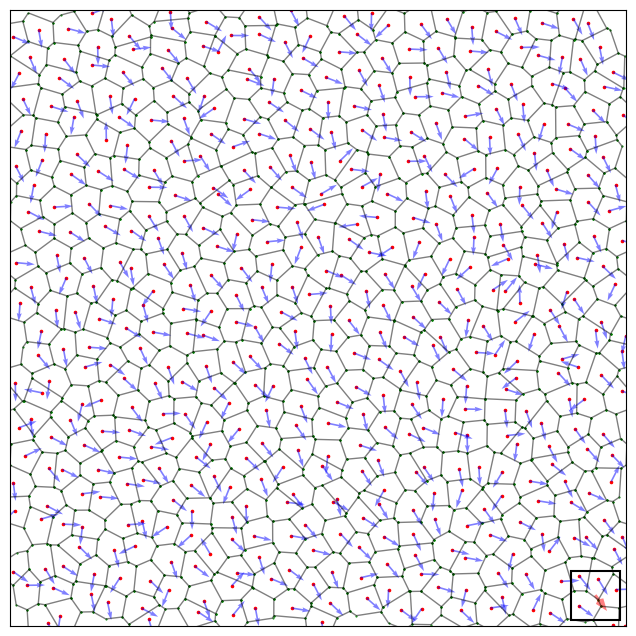

Cell A vertices: [[11.79094847 16.19065397]
 [12.01145324 15.92051156]
 [12.9040967  16.4532253 ]
 [13.01267877 17.1312493 ]
 [12.95664908 17.18932011]
 [12.59099378 17.29194042]]
Cell B vertices: [[13.28527437 18.14930052]
 [12.96342658 18.55383268]
 [12.2061443  18.29268908]
 [12.25975421 17.53251584]
 [12.59099378 17.29194042]
 [12.95664908 17.18932011]]
Shared vertices: [[12.95664908 17.18932011]
 [12.59099378 17.29194042]]
Indices of shared vertices in midpoint_vertices: 4, 5


(np.float64(2.611916891352246), np.float64(1.9254544655298593))

In [54]:
cells = voronoi_tessellation(pos, L, N)
vis.plot_voronoi(cells, pol, L, "voronoi_test", plot=True)
perimeeters, areas, adjacency_matrix = properties_of_voronoi_tessellation(cells)
cell_a = cells[0]
for i in range(1, len(cells)):
    cell_b = cells[i]
    if adjacency_matrix[0, i] == 1:
        break
# print("Cell A vertices:", np.array(cell_a['vertices']))
# print("Cell B vertices:", np.array(cell_b['vertices']))
get_interior_angles(cell_a, cell_b, L, debug=True)

The average area of a cell $\bar{A}$ is given by:
$$
\bar{A} = \frac{L^2}{N} \\
$$
The packing fraction $\phi$ relates the prefered area $A_0$ with the average area.
$$
A_0 = \phi \bar{A}\\
$$
This yields:
$$
L = \sqrt{\frac{A_0 N}{\phi}}
$$

For simplicity we assume the cells to be regular hexagons with the maximal diameter $D$ beinng the long diagonal. The area  is then given as:
$$
A = \frac{3\sqrt{3}}{8}D^2
$$
We can identify this ara with the average area $\bar{A}$ of the cells:
$$
\frac{A_0}{\phi} = \frac{3\sqrt{3}}{8}D^2
$$

### Mapping Simulation Box Size to Real Units

In the simulation, a confluent tissue of $N$ cells is enclosed in a square box of size $L^*$, where the preferred cell area is $A_0^* = 1.0$ in reduced units. The average area per cell is:

$$
\bar{A}^* = \frac{(L^*)^2}{N}
$$

Assuming a packing fraction $\phi$, which relates the preferred area to the average area as $A_0^* = \phi \bar{A}^*$, we obtain:

$$
L^* = \sqrt{\frac{A_0^* N}{\phi}}
$$

To convert to physical units, we estimate the physical preferred area $A_0$ from experimental cell sizes. Cells are approximated as regular hexagons with maximum diameter $D$, giving area:

$$
A_0 = \frac{3\sqrt{3}}{8} D^2
$$

The physical length scale per reduced unit is then:

$$
\ell = \sqrt{A_0}
$$

Therefore, the physical box size becomes:

$$
L = L^* \cdot \ell = \sqrt{\frac{A_0^* N}{\phi}} \cdot \sqrt{A_0}
$$

Combining all terms, the final expression for the physical box size is:

$$
\boxed{L = \sqrt{\frac{N}{\phi}} \cdot \sqrt{ \frac{3\sqrt{3}}{8} } \cdot D}
$$

This expression provides a direct link between simulation box size and experimental cell size.

In [9]:
cell_size_px_min = 16
cell_size_px_max = 24

px_size = 1.3

cell_size_min = cell_size_px_min * px_size
cell_size_max = cell_size_px_max * px_size

print("Cell size in pixels:", cell_size_px_min, "-", cell_size_px_max)
print("Cell size in micrometers:", cell_size_min, "-", cell_size_max)

Cell size in pixels: 16 - 24
Cell size in micrometers: 20.8 - 31.200000000000003



To determine the average pixel size in $\mathrm{\mu m}$ we need to consider the average diameter of a cell in experiment, which is given by 16-24px. With a pixel size of the microscope given by $\mathrm{1.3 \frac{\mu m}{px}}$. this gives us a average cell diameter of approximately 21-31 $\mathrm{\mu m}$.

The pixel size for the simulation can be caluclated using the lenght of the simulation box in pixels which is given by 1850 with
$$
\text{pixel size} = \frac{L (\mu m)}{1850}.
$$

Therefore, the pixel size in simulation is given by:
$$
\boxed{
\text{pixel size} = \frac{D}{1850} \cdot \sqrt{ \frac{3\sqrt{3}}{8} \cdot \frac{N}{\phi} }
}
$$


In [11]:
import numpy as np

def compute_pixel_size(D_um, N, phi, box_pixels=1850):
    """
    Compute the physical pixel size (in µm/px) of a simulation image.

    Parameters:
    ----------
    D_um : float
        Experimental cell diameter in micrometers (µm).
    N : int
        Number of cells in the simulation.
    phi : float
        Packing parameter (relates preferred area to average area).
    box_pixels : int, optional
        Width of the simulation box in pixels in the output image (default is 1850).

    Returns:
    -------
    pixel_size : float
        Pixel size in micrometers (µm/px).
    """
    # Geometric prefactor for area of regular hexagon
    area_prefactor = (3 * np.sqrt(3)) / 8
    
    # Compute pixel size
    pixel_size = (D_um / box_pixels) * np.sqrt(area_prefactor * N / phi)
    
    return pixel_size

In [12]:
N = 500        # number of cells
D = 26.0       # cell diameter in µm using the middle of the range

for phi in [0.25, 0.5, 1.0]:
    print(f"Packing parameter: {phi}")
    px_size = compute_pixel_size(D, N, phi)
    print(f"Pixel size: {px_size:.3f} µm/px\n")

Packing parameter: 0.25
Pixel size: 0.507 µm/px

Packing parameter: 0.5
Pixel size: 0.358 µm/px

Packing parameter: 1.0
Pixel size: 0.253 µm/px

